In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import datetime
import os
import pickle
import mlccd_models

# deactivate GPU on ragnarok
tf.config.set_visible_devices([], "GPU")

2024-09-03 23:00:29.078934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 23:00:29.096330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 23:00:29.101266: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 23:00:29.115681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 23:00:30.154675: W tensorflow/compiler/tf2

In [2]:
# Load the training and test data
data = mlccd_models.CCDData(
    '/home/erofors/repos/mlccd_geant4_sim/Geant4_CCD_simulation/output/quips_many_electron_50_2000keV.h5',
    # image_unit='keV',
)

In [3]:
# Filter out rows where energy_deposition_kev is between 0.7 and 0.9 times primary_energy_kev
mask = (data.tracks_metadata['energy_deposition_kev'] < 0.5 * data.tracks_metadata['primary_energy_kev']) | \
       (data.tracks_metadata['energy_deposition_kev'] >= 0.95 * data.tracks_metadata['primary_energy_kev'])
data.tracks_metadata = data.tracks_metadata[mask]
data.images = data.images[mask]

data.tracks_metadata['fully_contained'] = data.tracks_metadata['energy_deposition_kev'] >= 0.9 * data.tracks_metadata['primary_energy_kev']


In [4]:
# set the class labels based on the fully_contained column
data.labels = data.tracks_metadata['fully_contained'].astype(int).to_numpy()

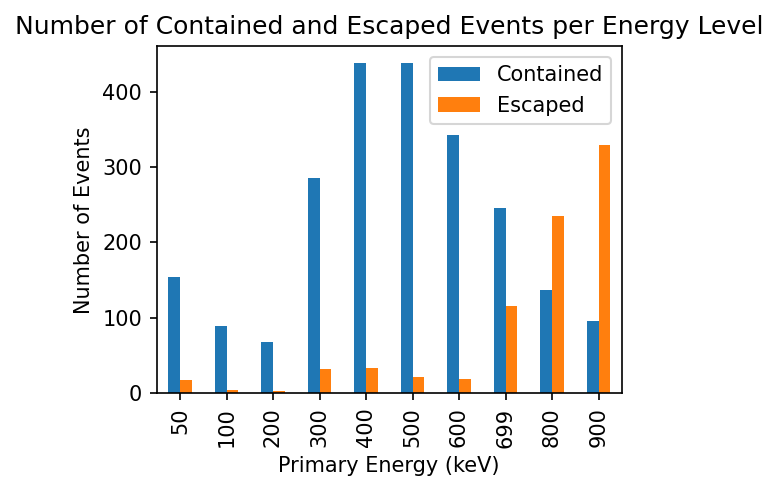

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract data
contained_indices = data.tracks_metadata.query('fully_contained == True').index
escaped_indices = data.tracks_metadata.query('fully_contained == False').index

# Group by energy and count events
contained_counts = data.tracks_metadata.loc[contained_indices].groupby('primary_energy_kev').size()
escaped_counts = data.tracks_metadata.loc[escaped_indices].groupby('primary_energy_kev').size()

# Create a DataFrame for plotting
df_counts = pd.DataFrame({
    'Contained': contained_counts,
    'Escaped': escaped_counts
}).fillna(0)  # Fill NaNs with 0

# Plot
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
df_counts.plot(kind='bar', ax=ax)
ax.set_xlabel('Primary Energy (keV)')
ax.set_ylabel('Number of Events')
ax.set_title('Number of Contained and Escaped Events per Energy Level')

# Round x-axis labels to integers
ax.set_xticklabels([int(float(label.get_text())) for label in ax.get_xticklabels()])

plt.show()

In [6]:
contained_indices = data.tracks_metadata.query('fully_contained == True').index
escaped_indices = data.tracks_metadata.query('fully_contained').index
escaped_indices_900 = data.tracks_metadata.query('fully_contained == False & primary_energy_kev == 900').index

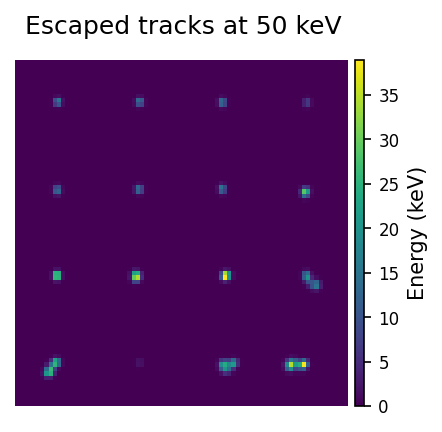

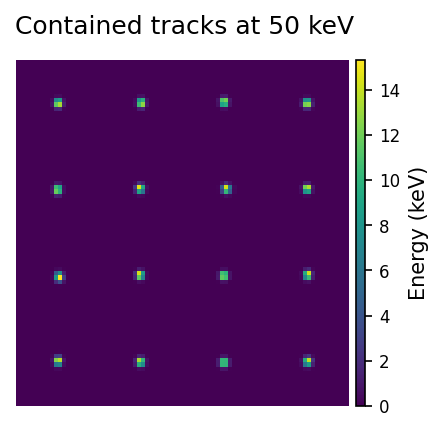

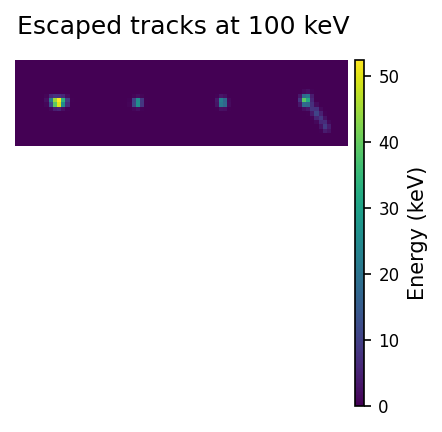

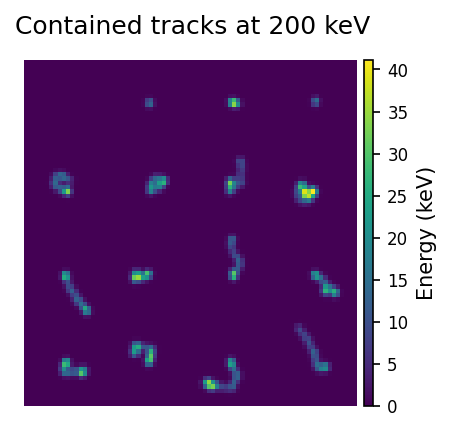

IndexError: index 3178 is out of bounds for axis 0 with size 3098

In [7]:
energies = [50, 100, 200, 400, 900]
for energy in energies:
    escaped_indices_energy = data.tracks_metadata.query(f'fully_contained == False & primary_energy_kev == {energy}').index
    mlccd_models.plot_12(data.images[escaped_indices_energy], title=f'Escaped tracks at {energy} keV')
    contained_indices_energy = data.tracks_metadata.query(f'fully_contained == True & primary_energy_kev == {energy}').index
    mlccd_models.plot_12(data.images[contained_indices_energy], title=f'Contained tracks at {energy} keV')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
fix, ax = plt.subplots(figsize=(4, 3), dpi=150)
# Assuming `data` is already defined and contains the images
ax.imshow(data.images[escaped_indices[45], :, :, 0], norm=LogNorm())
cax = ax.imshow(data.images[contained_indices[45], :, :, 0], norm=LogNorm())
cbar = fig.colorbar(cax, ax=ax, label="keV")  # Add a colorbar to visualize the scale
# hide the axes
ax.axis('off')

/tmp/ipykernel_649078/451589052.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 600x450 with 2 Axes> than <Figure size 600x450 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(cax, ax=ax, label="keV")  # Add a colorbar to visualize the scale


(-0.5, 19.5, 19.5, -0.5)

In [ ]:
data.divide_data(
    train_fraction=0.7, test_fraction=0.3, validation_fraction=0
)

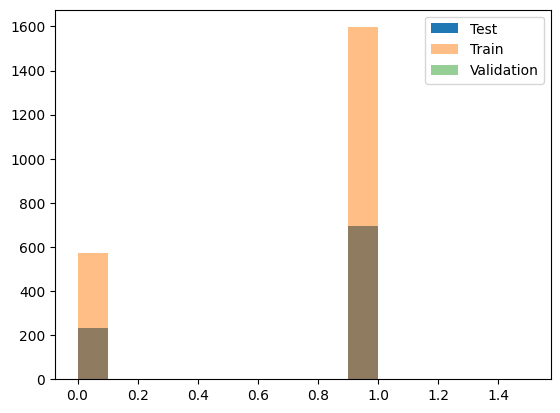

In [ ]:
plt.hist(data.y_test, label="Test")
plt.hist(data.y_train, label="Train", alpha=0.5)
plt.hist(data.y_validation, label="Validation", alpha=0.5)
plt.legend()

In [ ]:
# Assuming pos_weight is a scalar value
pos_weight = data.training_class_weights()[1]
gamma = 2
loss_function = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=gamma, from_logits=False, apply_class_balancing=True
)
# loss_function = 'binary_crossentropy'
config = {
    "model_name": f'cnn_{datetime.datetime.now().strftime("%Y%m%d_%H%M")}',
    "learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": data.file_path,
    "epochs": 25,
    "batch_size": 256 * 4,
    "loss_function": loss_function,
    "threshold_high": data.threshold_high,
    "threshold_low": data.threshold_low,
    "data_filename": data.file_path,
}


In [ ]:
# Create the model
model = mlccd_models.CNNModel(
    data.IMAGE_WIDTH,
    data.IMAGE_HEIGHT,
    data.IMAGE_CHANNELS,
)

adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate=config["learning_rate"]
)

model.compile(optimizer=adam_optimizer, loss=config["loss_function"])


In [ ]:
mlccd_models.train(model=model, config=config, ccd_data=data)

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step   loss: 0.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 586ms/step - loss: 0.3594 - val_loss: 0.1888
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  loss: 0.185
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1881 - val_loss: 0.1933
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  loss: 0.216
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2064 - val_loss: 0.1270
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  loss: 0.149
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.1503 - val_loss: 0.1330
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  loss: 0.127
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1259 - val_loss: 0.0794
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  loss: 0.104
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.1061 - val_loss: 0.0928
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  loss: 0.116
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1133 - val_loss: 0.0727
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

In [ ]:
y_pred = model.predict(data.x_test)
mlccd_models.plot_roc_curve(data.y_test, y_pred)

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Receiver Operating Characteristic'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

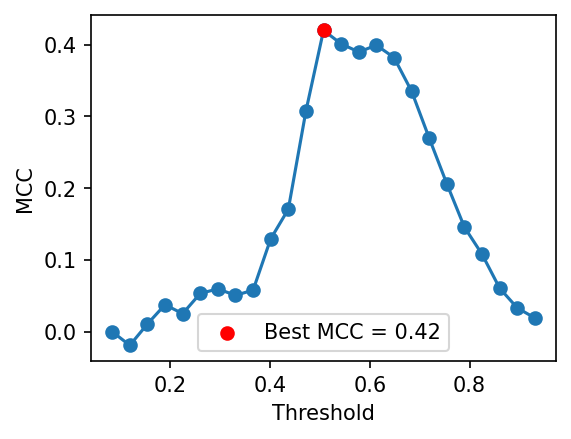

In [ ]:
max_mcc, mcc_threshold = (
    mlccd_models.scan_mcc(
        data.y_test, y_pred, plot=True
    )
)

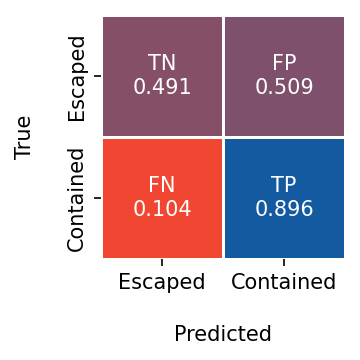

In [ ]:

_ = mlccd_models.plot_confusion_matrix(
    data.y_test, y_pred, threshold=mcc_threshold, class_names=["Escaped", "Contained"]
)

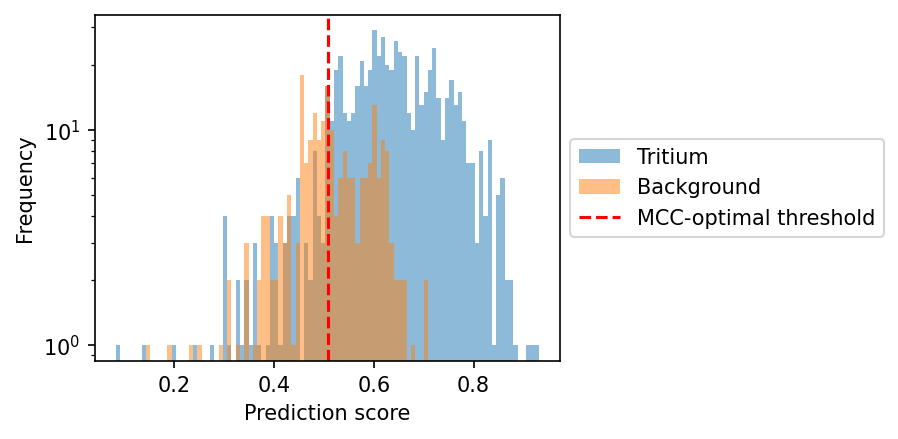

In [ ]:
fig, ax  = mlccd_models.plot_scores(data.y_test, y_pred, threshold_mcc_optimal=mcc_threshold)